### Library imports

In [88]:
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import calendar
import sys
e = 1e-100
try:
    import berserk #package to access lichess API
except:
    !{sys.executable} -m pip install berserk #install the package
    import berserk

### Who are we analysing??
Get your API token at https://lichess.org/account/oauth/token

In [154]:
name = 'EricRosen' #Lichess username you want to look up
token = None #Enter your lichess API token to download games
local_time_diff = -6 #Time difference from UTC in hours (EST: -5, CST: -6, CET: +1)

In [155]:
session = berserk.TokenSession(token)
client = berserk.Client(session)
games = None

_max = None #maximum number of games to download. None = all

ask = input('Do you want to download {} games by {}?\n\n'.format(_max if _max is not None else 'all', name))
if ask is not '':
    if ask[0].lower()=='y':
        print('Downloading...')
        games = list(client.games.export_by_player(name, max=_max, as_pgn=True))
        print('Done.')
    else:
        print('No games downloaded')
else:
    print('No games downloaded')

Do you want to download all games by EricRosen?

no
No games downloaded


### Open file and split into seperate games
#### and show example game

In [156]:
filename = name+'.txt' #enter (path+)filename here

if games is None:
    file = open(filename)
    text = file.read()
    games = re.split('\n\n\n',text)[:-1]
print(games[0])

[Event "Casual Blitz game"]
[Site "https://lichess.org/FKFHeB0u"]
[Date "2019.12.08"]
[Round "-"]
[White "EricRosen"]
[Black "chessonmars"]
[Result "1-0"]
[UTCDate "2019.12.08"]
[UTCTime "18:55:49"]
[WhiteElo "2535"]
[BlackElo "1665"]
[WhiteTitle "IM"]
[Variant "Standard"]
[TimeControl "300+3"]
[ECO "A00"]
[Termination "Normal"]

1. g4 d5 2. Bg2 c6 3. c4 e6 4. b3 h6 5. Bb2 Qb6 6. Qc2 Ne7 7. Nf3 Ng6 8. e3 Na6 9. h4 Nb4 10. Qc3 Rg8 11. a3 Na6 12. h5 Nh8 13. b4 f6 14. Nh4 Bd7 15. c5 Qc7 16. f4 O-O-O 17. a4 Be8 18. Na3 Nb8 19. b5 Qe7 20. Nf3 Qxc5 21. Qxc5 Bxc5 22. Rc1 Bxa3 23. Bxa3 g6 24. Nd4 Bd7 25. Be7 Rde8 26. Bxf6 g5 27. fxg5 hxg5 28. a5 Ref8 29. Be7 Rf7 30. Bd6 e5 31. Bxe5 Kd8 32. Bxb8 Ke7 33. bxc6 Bxg4 34. c7 Bc8 35. Bxd5 Kd6 36. e4 Rgf8 37. Bxb7 g4 38. Nf5+ Ke5 39. Rc5+ Kf6 40. Rc6+ Ke5 41. d4+ Kf4 42. Rc5 Re8 43. Nd6 Rfe7 44. e5 Nf7 45. Nxe8 Rxe8 46. Bxc8 Rxc8 47. e6 Nd6 48. e7 Ne4 49. h6 g3 50. Rc2 Kg5 51. h7 Nf6 52. Rg2 Nxh7 53. Rxg3+ Kf4 54. Rg6 Ng5 55. Rf6+ Kg4 56. d5 Nf3+ 57. 

### Extract metadata rows and turn it into a a list of dictionaries
##### E.g: "Event" : "Casual Blitz game", " Date" : "2019.12.08", ... for every game

In [157]:
metaDataRegex = re.compile('(\w+) "(.*)"', re.MULTILINE)
movesRegex = re.compile(']\n\n(.*) [012/\-]{3,}')
metaData = []
moves = []

for game in games:
    moves.append(re.search(movesRegex, game).group(1))
    gameData = {}
    for (key, value) in re.findall(metaDataRegex, game):
        gameData[key] = value
    metaData.append(gameData.copy())

### Create pandas dataframe of the data for ultimate data science

In [158]:
columns = list(metaData[max([len(x) for x in metaData])].keys())
d = pd.DataFrame(metaData, columns = columns)
d['Moves'] = moves

In [159]:
#drop games started from a position. I assume these are student games
d = d[d.Variant != 'From Position']

### Define functions to create more columns in the dataframe

In [160]:
def isWin(game):
    if game['Result'] == "1/2-1/2":
        return "Draw"
    elif (game['Result'] == "1-0" and game['White'] == name) or \
       (game['Result'] == "0-1" and game['Black'] == name):
        return "Win"
    return "Loss"

def nrMoves(game):
    return game['Moves'].count('.')

months = list(map(lambda x: x[:3], calendar.month_name[1:]))

def getYear(game):
    return game['Date'].split('.')[0]

def getMonth(game):
    return months[int(game['Date'].split('.')[1])-1]

def localtime(game):
    return (int(game['UTCTime'].split(':')[0])+local_time_diff)%24 

### Add columns with data derived by those functions

In [161]:
d['Outcome'] = d.apply(isWin, axis=1)
d['NrMoves'] = d.apply(nrMoves, axis=1)
d['Year'] = d.apply(getYear, axis=1)
d['Month'] = d.apply(getMonth, axis=1)
d['LocalHour'] = d.apply(localtime, axis=1)

In [162]:
def mateOrResign(game):
    if game['Termination'] == 'Abandoned' or game['Termination'] == 'Time forfeit':
        return game['Termination']
    try: #sometimes a game has no moves. I'll say it's abandoned
        if game['Termination'] == 'Normal':
            if game['Moves'][-1] == '#':
                return 'Checkmate'
            elif game['Outcome'] == 'Draw':
                return 'Other'
            return 'Resign'    
    except:
        return 'Abandoned'

In [163]:
new_terminations = d.apply(mateOrResign, axis=1)
d.Termination = new_terminations

#### What's in the dataframe now?

In [164]:
print(", ".join(d.columns))
d.loc[0]

Event, Site, Date, Round, White, Black, Result, UTCDate, UTCTime, WhiteElo, BlackElo, WhiteRatingDiff, BlackRatingDiff, WhiteTitle, Variant, TimeControl, ECO, Termination, Moves, Outcome, NrMoves, Year, Month, LocalHour


Event                                              Casual Blitz game
Site                                    https://lichess.org/FKFHeB0u
Date                                                      2019.12.08
Round                                                              -
White                                                      EricRosen
Black                                                    chessonmars
Result                                                           1-0
UTCDate                                                   2019.12.08
UTCTime                                                     18:55:49
WhiteElo                                                        2535
BlackElo                                                        1665
WhiteRatingDiff                                                  NaN
BlackRatingDiff                                                  NaN
WhiteTitle                                                        IM
Variant                           

## FUN TIME

### Nr of moves analyses

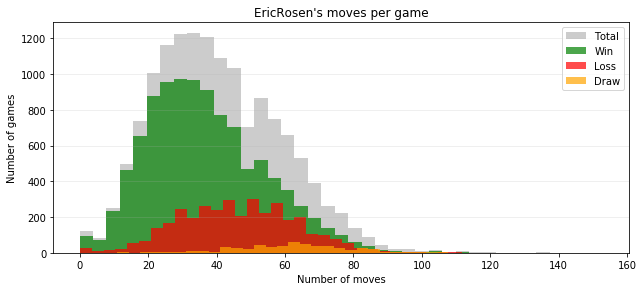

In [166]:
#Make figure
plt.figure(figsize=(8, 4));
plt.axes([0, 0.6, 1, .8]);

#Histograms
bins = len(d.NrMoves.unique())//3
d.NrMoves.hist(bins=bins, color='black', alpha=.2, grid=False);


d.loc[d.Outcome=="Win"].NrMoves.hist(bins=bins, color='g', alpha=.7, grid=False);
d.loc[d.Outcome=="Loss"].NrMoves.hist(bins=bins, color='r', alpha=.7, grid=False);
d.loc[d.Outcome=="Draw"].NrMoves.hist(bins=bins, color='orange', alpha=.7, grid=False);

#Meta
plt.legend(['Total', 'Win', 'Loss', 'Draw']);
plt.grid(axis='y', alpha=0.25)
plt.title('{}\'s moves per game'.format(name));
plt.xlabel("Number of moves");
plt.ylabel("Number of games");

In [167]:
wins = d.loc[d.Outcome == "Win"]
losses = d.loc[d.Outcome == "Loss"]

In [168]:
print('All:\n', d.NrMoves.describe(),'\n\n')
print('Wins:\n', wins.NrMoves.describe(),'\n\n')
print('Losses:\n',losses.NrMoves.describe())

All:
 count    14384.000000
mean        40.211555
std         18.212381
min          0.000000
25%         27.000000
50%         38.000000
75%         52.000000
max        153.000000
Name: NrMoves, dtype: float64 


Wins:
 count    10290.000000
mean        36.914286
std         17.203149
min          0.000000
25%         24.000000
50%         35.000000
75%         48.000000
max        153.000000
Name: NrMoves, dtype: float64 


Losses:
 count    3555.000000
mean       46.397187
std        17.267901
min         0.000000
25%        34.000000
50%        46.000000
75%        58.000000
max       136.000000
Name: NrMoves, dtype: float64


### Date & Time vs. Activity

In [169]:
#select years and months
start_year = d.Year.unique()[-1]
start_month = d.Date.unique()[-1].split('.')[1]
end_month = d.Date.unique()[0].split('.')[1]

years = list(np.array([12*([year]) for year in d.Year.unique()]).flatten()[::-1]) 
years = years[int(start_month)-1:len(years)+(int(end_month)-12)] #select years 
months = (len(d.Year.unique())*list(map(lambda x: x[:3], calendar.month_name[1:])))
months = months[int(start_month)-1:len(months)+(int(end_month)-12)]

xs = ['{}, {}'.format(months[i], years[i]) for i in range(len(years))]

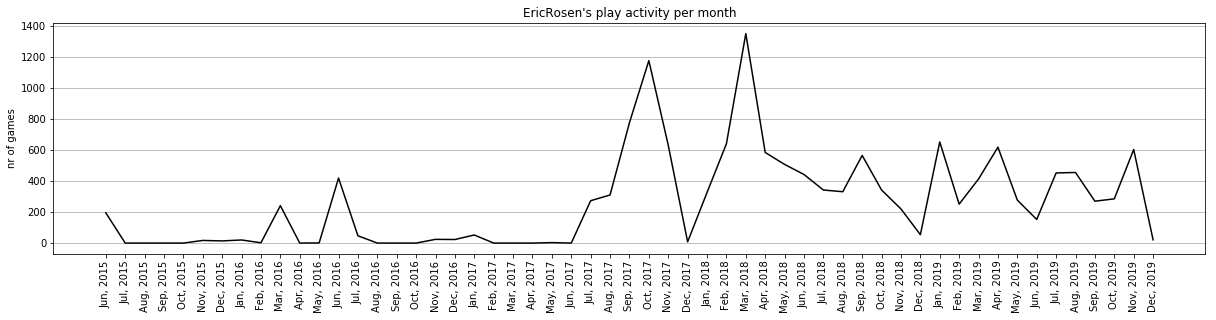

In [170]:
plt.figure(figsize=(8, 4));
plt.axes([0, 0.6, 2, .8]);
plt.plot(xs, [len(d[(d.Month==months[i]) & (d.Year==years[i])]) for i in range(len(years))], 'black');
plt.xticks(rotation='vertical');
plt.title("{}'s play activity per month".format(name));
plt.ylabel("nr of games");
plt.grid(axis='y');

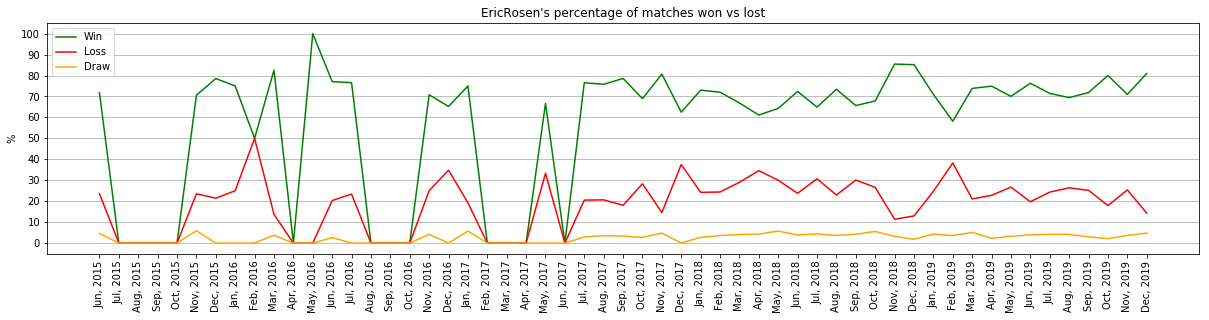

In [171]:
games_in_month = [d[(d.Month==months[i]) & (d.Year==years[i])] for i in range(len(years))]
wins_in_month = [len(games_in_month[i].loc[games_in_month[i].Outcome=='Win']) / (len(games_in_month[i])+e)*100\
                for i in range(len(years))] 
losses_in_month = [len(games_in_month[i].loc[games_in_month[i].Outcome=='Loss']) / (len(games_in_month[i])+e)*100\
                for i in range(len(years))] 
draws_in_month = [len(games_in_month[i].loc[games_in_month[i].Outcome=='Draw']) / (len(games_in_month[i])+e)*100\
                for i in range(len(years))] 

plt.figure(figsize=(8, 4));
plt.axes([0, 0.6, 2, .8]);
plt.plot(xs, wins_in_month, 'g', label='Win');
plt.plot(xs, losses_in_month, 'r', label='Loss');
plt.plot(xs, draws_in_month, 'orange', label='Draw')
plt.xticks(rotation='vertical');
plt.yticks(range(0,101,10))
plt.title("{}'s percentage of matches won vs lost".format(name));
plt.legend()
plt.ylabel("%");
plt.grid(axis='y');

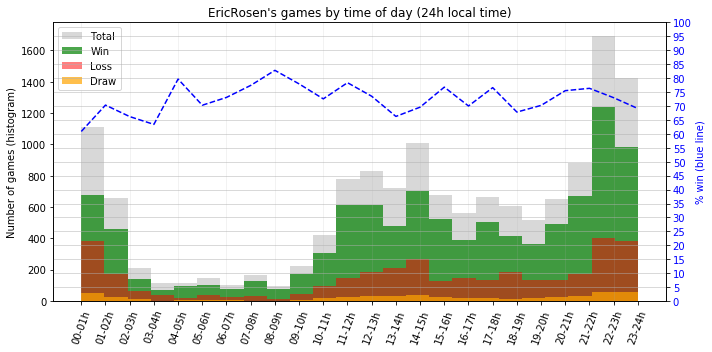

In [172]:
fig, ax = plt.subplots(figsize=(10,5))

wins_hours = d[d.Outcome=='Win']
loss_hours = d[d.Outcome=='Loss']
draw_hours = d[d.Outcome=='Draw']

d.LocalHour.hist(bins=24, grid=False, color='gray', alpha=.3, ax=ax, label="Total")
if len(loss_hours)<len(wins_hours):
    wins_hours.LocalHour.hist(bins=24, grid=False, color='g', alpha=.7, ax=ax, label="Win")
    loss_hours.LocalHour.hist(bins=24, grid=False, color='r', alpha=.5, ax=ax, label="Loss")
else:
    loss_hours.LocalHour.hist(bins=24, grid=False, color='r', alpha=.5, ax=ax, label='Loss')
    wins_hours.LocalHour.hist(bins=24, grid=False, color='g', alpha=.7, ax=ax, label='Win')
draw_hours.LocalHour.hist(bins=24, grid=False, color='orange', alpha=.7, ax=ax, label="Draw");

ax2 = ax.twinx()
percentage_wins = [len(wins_hours[wins_hours.LocalHour==hour])/(len(d[(d.LocalHour==hour)])+e)*100 \
                   for hour in range(24)]
ax2.plot(percentage_wins, 'b--')
ax2.set_ylabel('% win (blue line)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
plt.sca(ax2)
plt.yticks(range(0,101,5))

plt.grid(axis='y', alpha=.6)
plt.title('{}\'s games by time of day (24h local time)'.format(name));
plt.sca(ax)
plt.ylabel("Number of games (histogram)")
plt.xticks(range(24), map(lambda x: str.format('{:02}-{:02}h',x,x+1), range(24)), rotation='70')
ax.set_xticks(range(0,24,2), minor=True)
plt.grid(which='minor', alpha=.2)
plt.legend()
fig.tight_layout()
plt.show()

### Winning and losing in various ways

In [173]:
d.Termination.value_counts()

Time forfeit    5031
Checkmate       4637
Resign          4259
Other            393
Abandoned         64
Name: Termination, dtype: int64

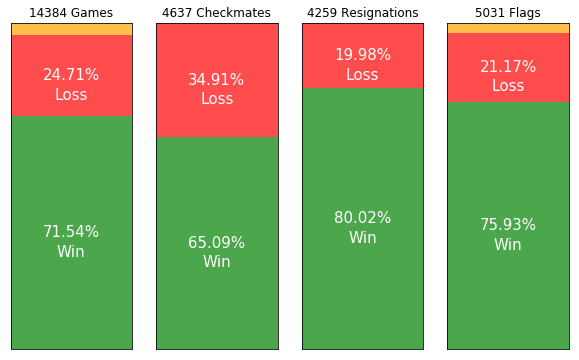

In [174]:
fig = plt.figure(figsize=(10,6), frameon=False)
# plt.xticks(range(5))
# plt.tick_params(
#     axis='both',       # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     left=False,
#     right=False,
#     labelbottom=False,
#     labelleft=False)
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)
ax1.title.set_text("{} Games".format(len(d)))
ax2.title.set_text("{} Checkmates".format(len(d[d.Termination=='Checkmate'])))
ax3.title.set_text("{} Resignations".format(len(d[d.Termination=='Resign'])))
ax4.title.set_text("{} Flags".format(len(d[d.Termination=='Time forfeit'])))
titles = ['', 'Checkmate', 'Resign', 'Time forfeit']

for i, ax in enumerate([ax1,ax2,ax3,ax4]):
    if titles[i] is not '':
        d_ = d[d.Termination==titles[i]]
    else:
        d_ = d
    value_counts = d_.Outcome.value_counts()
    
    ax.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False)
    
    win_percentage = value_counts['Win']/value_counts.sum()
    lose_percentage = value_counts['Loss']/value_counts.sum()
    
    ax.add_patch(patches.Rectangle((0,win_percentage+lose_percentage),1, 1, facecolor='orange', alpha=.7));
    ax.add_patch(patches.Rectangle((0,0), 1, win_percentage, facecolor='g', alpha=.7));
    ax.add_patch(patches.Rectangle((0,win_percentage),1, lose_percentage,  facecolor='r', alpha=.7));
    
    ax.text(.5,win_percentage/2,'{:.2f}%'.format(win_percentage*100), size=15, color='white',ha='center', va='center');
    ax.text(.5,win_percentage+lose_percentage/2,'{:.2f}%'.format(lose_percentage*100), size=15, color='white',ha='center', va='center');

    ax.text(.5,win_percentage/2-.06,'Win', size=15, color='white',ha='center', va='center');
    ax.text(.5,win_percentage+lose_percentage/2-.06,'Loss', size=15, color='white',ha='center', va='center');